In [1]:
# refer to https://www.kaggle.com/general/74235

from google.colab import files
import os
def import_the_dataset_kaggle(api_command):
  !pip install -q kaggle
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  os.system(api_command)
  ! mkdir train
  os.system("unzip best-artworks-of-all-time.zip -d train/")
  os.system("rm best-artworks-of-all-time.zip")

import_the_dataset_kaggle('kaggle datasets download -d ikarus777/best-artworks-of-all-time')

Saving kaggle.json to kaggle.json


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

print(tf.__version__)

2.3.0


In [3]:
TRAIN_DIR = '/content/train/images/images'

In [4]:
artists_df = pd.read_csv('/content/train/artists.csv')
artists_df.drop(['id', 'bio', 'wikipedia'], axis=1, inplace=True)
artists_df.head()

name        years  ... nationality paintings
0   Amedeo Modigliani  1884 - 1920  ...     Italian       193
1  Vasiliy Kandinskiy  1866 - 1944  ...     Russian        88
2        Diego Rivera  1886 - 1957  ...     Mexican        70
3        Claude Monet  1840 - 1926  ...      French        73
4       Rene Magritte  1898 - 1967  ...     Belgian       194

[5 rows x 5 columns]

In [5]:
artists_df = artists_df.sort_values(by=['paintings'], ascending=False)
artists_top = artists_df[artists_df['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223

In [6]:
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [7]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [8]:
artists_top_name = artists_top['name'].str.replace(' ', '_')

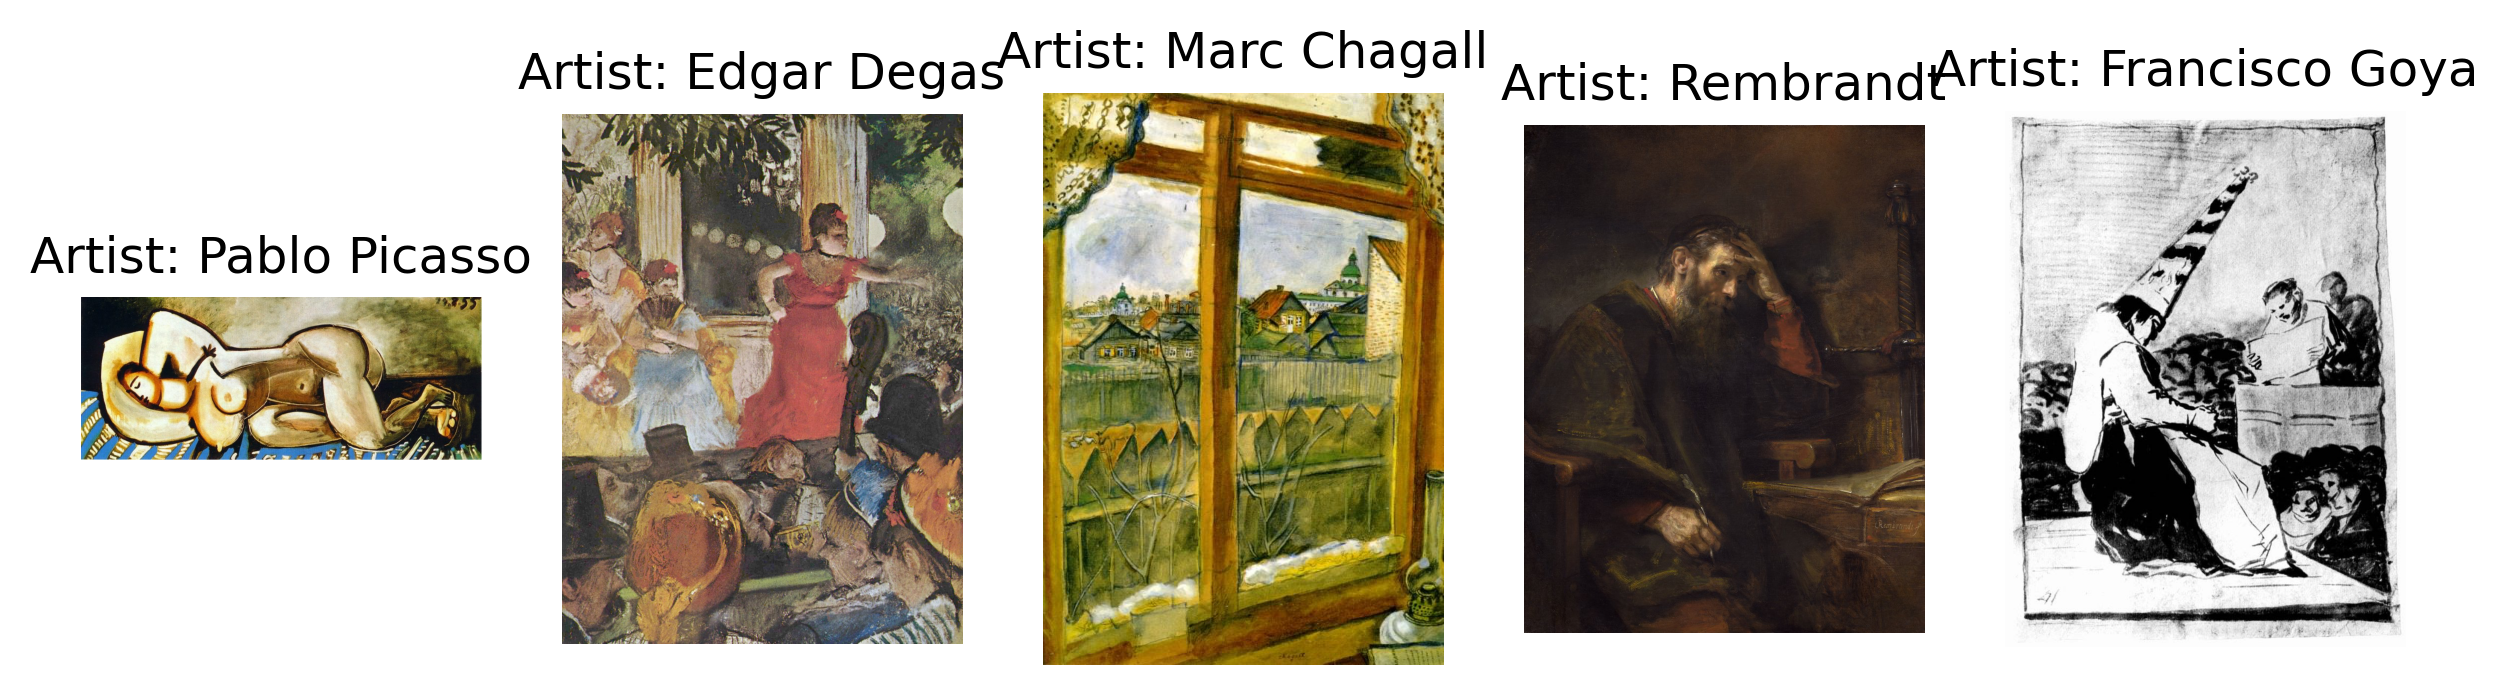

In [9]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(10, 30), dpi=300)

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(TRAIN_DIR, random_artist)))
    random_image_file = os.path.join(TRAIN_DIR, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [10]:
batch_size = 32
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
print(f"Total number of Train Batches: {STEP_SIZE_TRAIN}, Validation Batches: {STEP_SIZE_VALID}")

Found 3181 images belonging to 11 classes.
Found 790 images belonging to 11 classes.
Total number of Train Batches: 99, Validation Batches: 24


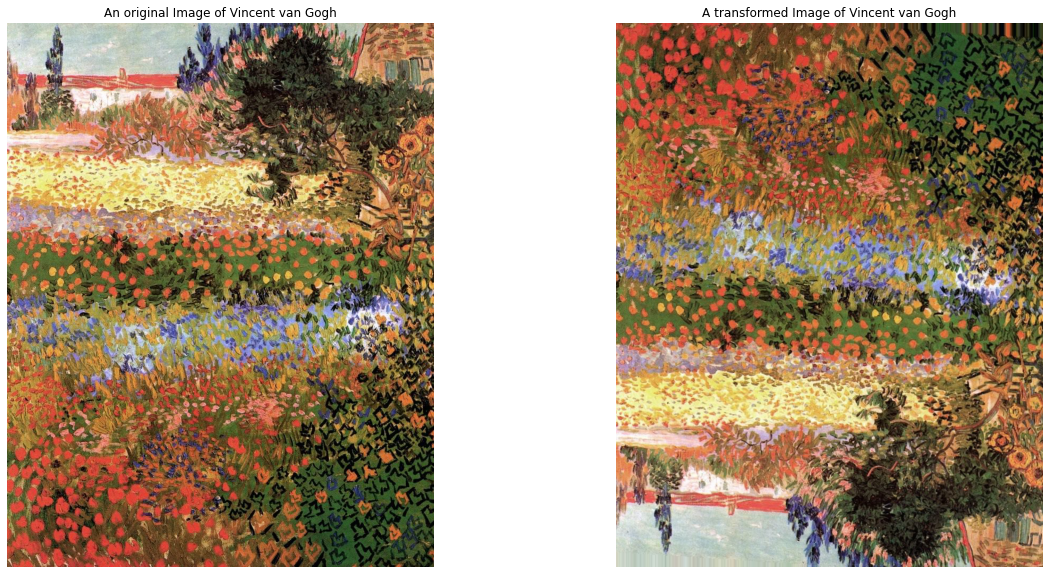

In [11]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(TRAIN_DIR, random_artist)))
random_image_file = os.path.join(TRAIN_DIR, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## ResNet50 Model [Training the core layers + Training only the top Layers]

In [12]:
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in resnet_base_model.layers:
    layer.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [13]:
# Add layers at the end
X_resnet = resnet_base_model.output
X_resnet = Flatten()(X_resnet)

X_resnet = Dense(512, kernel_initializer='he_uniform')(X_resnet)
# X = Dropout(0.5)(X) 
X_resnet = BatchNormalization()(X_resnet)
X_resnet = Activation('relu')(X_resnet)

X_resnet = Dense(16, kernel_initializer='he_uniform')(X_resnet)
# X = Dropout(0.5)(X)
X_resnet = BatchNormalization()(X_resnet)
X_resnet = Activation('relu')(X_resnet)

resnet_output = Dense(n_classes, activation='softmax')(X_resnet)

resnet_model = Model(inputs=resnet_base_model.input, outputs=resnet_output)

In [14]:
optimizer = Adam(lr=0.0001)
resnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
n_epoch = 10
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [16]:
resnet_history1 = resnet_model.fit_generator(generator=train_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, 
                              validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              class_weight=class_weights
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
99/99 [==============================] - 107s 1s/step - loss: 1.5928 - accuracy: 0.5017 - val_loss: 2.3231 - val_accuracy: 0.1784
Epoch 2/10
99/99 [==============================] - 108s 1s/step - loss: 1.1868 - accuracy: 0.7034 - val_loss: 2.5751 - val_accuracy: 0.0742
Epoch 3/10
99/99 [==============================] - 107s 1s/step - loss: 1.0448 - accuracy: 0.7933 - val_loss: 2.7203 - val_accuracy: 0.0742
Epoch 4/10
99/99 [==============================] - 106s 1s/step - loss: 0.9284 - accuracy: 0.8727 - val_loss: 2.4758 - val_accuracy: 0.0651
Epoch 5/10
99/99 [==============================] - 106s 1s/step - loss: 0.8181 - accuracy: 0.9232 - val_loss: 2.6027 - val_accuracy: 0.0716
Epoch 6/10
99/99 [==============================] - ETA: 0s - loss: 0.7507 - accuracy: 0.9381
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
99/99 [==============================] - 106s

In [17]:
# Freeze core ResNet layers and train again 
for layer in resnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

resnet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
resnet_history2 = resnet_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              class_weight=class_weights
                             )

Epoch 1/10
99/99 [==============================] - 105s 1s/step - loss: 0.5132 - accuracy: 0.9848 - val_loss: 1.1332 - val_accuracy: 0.7135
Epoch 2/10
99/99 [==============================] - 104s 1s/step - loss: 0.4741 - accuracy: 0.9825 - val_loss: 0.9589 - val_accuracy: 0.7799
Epoch 3/10
99/99 [==============================] - 104s 1s/step - loss: 0.4486 - accuracy: 0.9829 - val_loss: 0.8430 - val_accuracy: 0.8242
Epoch 4/10
99/99 [==============================] - 105s 1s/step - loss: 0.4324 - accuracy: 0.9816 - val_loss: 0.8167 - val_accuracy: 0.8177
Epoch 5/10
99/99 [==============================] - 104s 1s/step - loss: 0.4224 - accuracy: 0.9809 - val_loss: 0.8565 - val_accuracy: 0.7956
Epoch 6/10
99/99 [==============================] - 104s 1s/step - loss: 0.4044 - accuracy: 0.9749 - val_loss: 0.8137 - val_accuracy: 0.8138
Epoch 7/10
99/99 [==============================] - 104s 1s/step - loss: 0.3864 - accuracy: 0.9816 - val_loss: 0.8025 - val_accuracy: 0.8229
Epoch 8/10
99

In [18]:
# Merge history1 and history2
resnet_history = {}
resnet_history['loss'] = resnet_history1.history['loss'] + resnet_history2.history['loss']
resnet_history['acc'] = resnet_history1.history['accuracy'] + resnet_history2.history['accuracy']
resnet_history['val_loss'] = resnet_history1.history['val_loss'] + resnet_history2.history['val_loss']
resnet_history['val_acc'] = resnet_history1.history['val_accuracy'] + resnet_history2.history['val_accuracy']
resnet_history['lr'] = resnet_history1.history['lr'] + resnet_history2.history['lr']

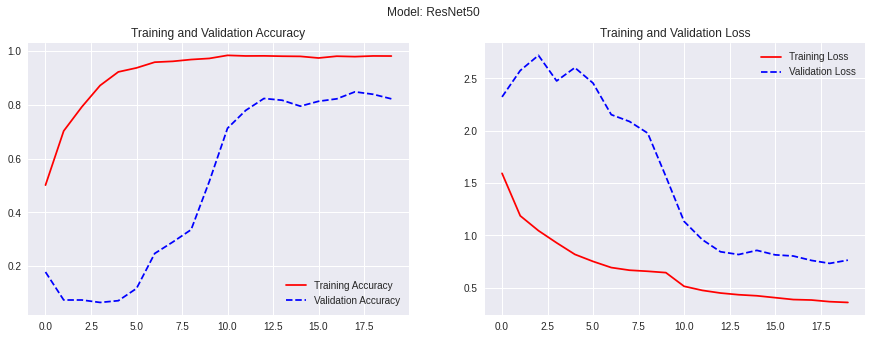

In [19]:
plt.style.use('seaborn')
# Plot the training graph
def plot_training(history, model_name):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    fig.suptitle(f'Model: {model_name}')
    plt.savefig(f'{model_name}_plots.png')
    plt.show()
    
    
plot_training(resnet_history, 'ResNet50')

In [20]:
# Prediction accuracy on train data
resnet_score = resnet_model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on Training Data: ", resnet_score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
100/100 [==============================] - 78s 783ms/step - loss: 0.3559 - accuracy: 0.9818
Prediction accuracy on Training Data:  0.9817667603492737


In [21]:
# Prediction accuracy on CV data
resnet_score = resnet_model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV Data: ", resnet_score[1])

25/25 [==============================] - 19s 744ms/step - loss: 0.7397 - accuracy: 0.8367
Prediction accuracy on CV Data:  0.8367088437080383


In [22]:
# get predictions 
def get_predictions_and_labels(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    return y_pred, y_true

In [23]:
p_valid, y_valid = get_predictions_and_labels(resnet_model, valid_generator, STEP_SIZE_VALID)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(p_valid, y_valid)

In [25]:
import pandas as pd
import seaborn as sn
def plot_confusion_matrix(cm, model_name):
  df_cm = pd.DataFrame(
      cm,  
      index=[artists_top_name.iloc[i].replace('_', ' ') for i in range(artists_top_name.shape[0] - 1)], 
      columns=[artists_top_name.iloc[i].replace('_', ' ') for i in range(artists_top_name.shape[0] - 1)]
  )
  plt.figure(figsize=(15, 10))
  sns_plot = sn.heatmap(df_cm, annot=False)
  fig = sns_plot.get_figure()
  fig.savefig(f'{model_name}_confusionMatrix.png') 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0, flags=flags)


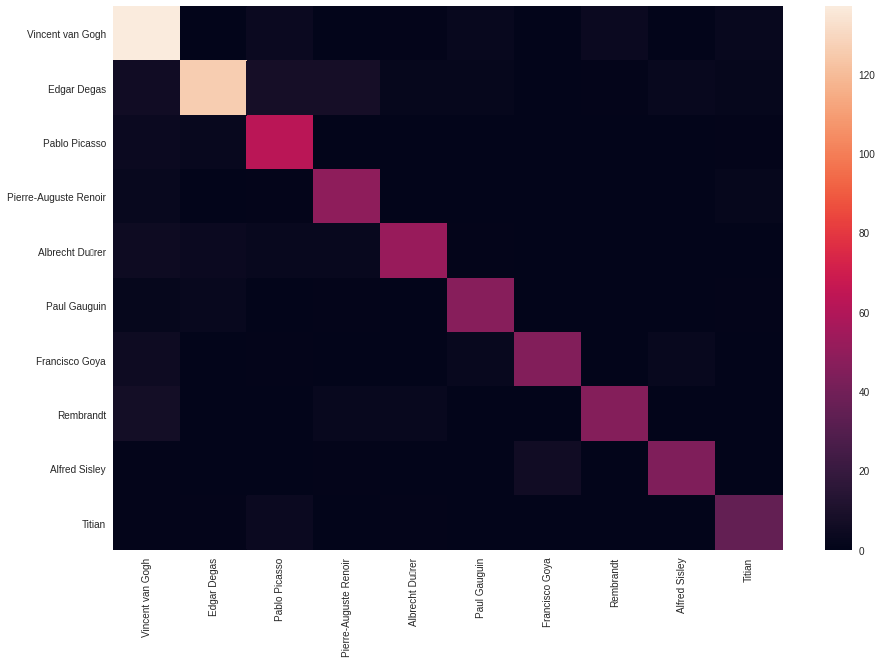

In [26]:
plot_confusion_matrix(cm, 'ResNet50')

## VGG16 [Training Core layers + Training only the top layers]

In [27]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_input_shape)
for layer in vgg16_base_model.layers:
    layer.trainable = True

58892288/58889256 [==============================] - 0s 0us/step


In [28]:
# Add layers at the end
X_vgg = vgg16_base_model.output
X_vgg = Flatten()(X_vgg)

X_vgg = Dense(256, kernel_initializer='he_uniform')(X_vgg)
# X = Dropout(0.5)(X) 
X_vgg = BatchNormalization()(X_vgg)
X_vgg = Activation('relu')(X_vgg)

X_resnet = Dense(128, kernel_initializer='he_uniform')(X_resnet)
# X = Dropout(0.5)(X)
X_vgg = BatchNormalization()(X_vgg)
X_vgg = Activation('relu')(X_vgg)

vgg_output = Dense(n_classes, activation='softmax')(X_vgg)

vgg_model = Model(inputs=vgg16_base_model.input, outputs=vgg_output)

In [29]:
optimizer = Adam(lr=0.0001)
vgg_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [30]:
n_epoch = 10
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [31]:
vgg_history1 = vgg_model.fit_generator(generator=train_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, 
                              validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              class_weight=class_weights
                             )

Epoch 1/10
99/99 [==============================] - 110s 1s/step - loss: 1.6883 - accuracy: 0.3773 - val_loss: 10.9599 - val_accuracy: 0.0586
Epoch 2/10
99/99 [==============================] - 108s 1s/step - loss: 1.2130 - accuracy: 0.5459 - val_loss: 2.0192 - val_accuracy: 0.4622
Epoch 3/10
99/99 [==============================] - 109s 1s/step - loss: 1.0029 - accuracy: 0.6285 - val_loss: 4.0769 - val_accuracy: 0.2930
Epoch 4/10
99/99 [==============================] - 109s 1s/step - loss: 0.8811 - accuracy: 0.6621 - val_loss: 2.3261 - val_accuracy: 0.4609
Epoch 5/10
99/99 [==============================] - 108s 1s/step - loss: 0.7996 - accuracy: 0.6926 - val_loss: 2.4380 - val_accuracy: 0.3672
Epoch 6/10
99/99 [==============================] - 109s 1s/step - loss: 0.6999 - accuracy: 0.7310 - val_loss: 1.1796 - val_accuracy: 0.6510
Epoch 7/10
99/99 [==============================] - 109s 1s/step - loss: 0.6375 - accuracy: 0.7653 - val_loss: 1.4311 - val_accuracy: 0.5547
Epoch 8/10
9

In [32]:
# Freeze core ResNet layers and train again 
for layer in vgg_model.layers:
    layer.trainable = False

for layer in vgg_model.layers[16:]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
vgg_history2 = vgg_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              class_weight=class_weights
                             )

Epoch 1/10
99/99 [==============================] - 100s 1s/step - loss: 0.3630 - accuracy: 0.8615 - val_loss: 1.2163 - val_accuracy: 0.6406
Epoch 2/10
99/99 [==============================] - 98s 988ms/step - loss: 0.3287 - accuracy: 0.8733 - val_loss: 0.7610 - val_accuracy: 0.7513
Epoch 3/10
99/99 [==============================] - 98s 988ms/step - loss: 0.2949 - accuracy: 0.8787 - val_loss: 1.1263 - val_accuracy: 0.6549
Epoch 4/10
99/99 [==============================] - 98s 988ms/step - loss: 0.2678 - accuracy: 0.8943 - val_loss: 0.7990 - val_accuracy: 0.7565
Epoch 5/10
99/99 [==============================] - 98s 986ms/step - loss: 0.2392 - accuracy: 0.9089 - val_loss: 0.7938 - val_accuracy: 0.7435
Epoch 6/10
99/99 [==============================] - 98s 988ms/step - loss: 0.2317 - accuracy: 0.9044 - val_loss: 0.9092 - val_accuracy: 0.7227
Epoch 7/10
99/99 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9165
Epoch 00007: ReduceLROnPlateau reducing learning r

In [33]:
# Merge history1 and history2
vgg_history = {}
vgg_history['loss'] = vgg_history1.history['loss'] + vgg_history2.history['loss']
vgg_history['acc'] = vgg_history1.history['accuracy'] + vgg_history2.history['accuracy']
vgg_history['val_loss'] = vgg_history1.history['val_loss'] + vgg_history2.history['val_loss']
vgg_history['val_acc'] = vgg_history1.history['val_accuracy'] + vgg_history2.history['val_accuracy']
vgg_history['lr'] = vgg_history1.history['lr'] + vgg_history2.history['lr']

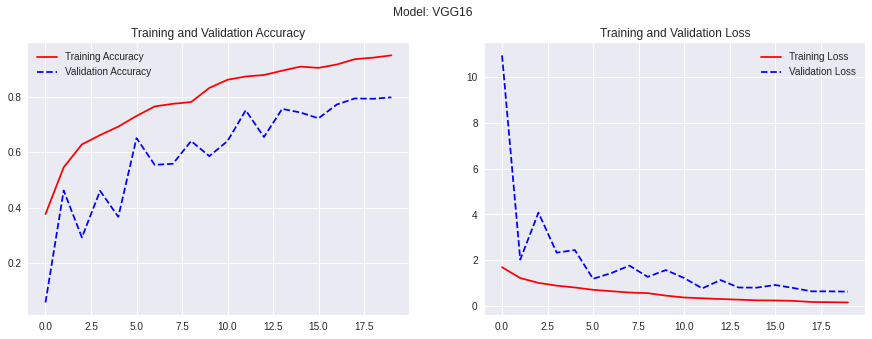

In [34]:
plt.style.use('seaborn')
plot_training(vgg_history, 'VGG16')

In [35]:
# Prediction accuracy on train data
vgg_score = vgg_model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on Training Data: ", vgg_score[1])

100/100 [==============================] - 78s 783ms/step - loss: 0.1546 - accuracy: 0.9554
Prediction accuracy on Training Data:  0.955359935760498


In [36]:
# Prediction accuracy on CV data
vgg_score = vgg_model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV Data: ", vgg_score[1])

25/25 [==============================] - 20s 783ms/step - loss: 0.6088 - accuracy: 0.8000
Prediction accuracy on CV Data:  0.800000011920929


In [37]:
p_valid, y_valid = get_predictions_and_labels(vgg_model, valid_generator, STEP_SIZE_VALID)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0, flags=flags)


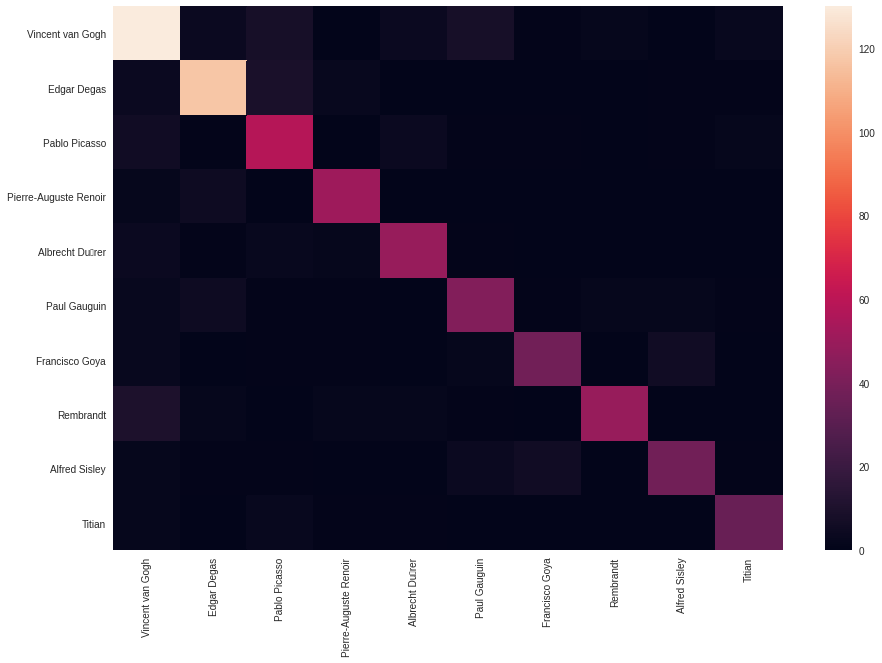

In [38]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(p_valid, y_valid)
plot_confusion_matrix(cm, 'VGG16')

## Custom CNN

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), input_shape=train_input_shape))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(32, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Flatten())
custom_model.add(Dense(64))
custom_model.add(Activation('relu'))
custom_model.add(Dropout(0.5))
custom_model.add(Dense(n_classes))
custom_model.add(Activation('softmax'))

In [40]:
custom_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
n_epoch = 10
custom_history = custom_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              class_weight=class_weights
                             )

Epoch 1/10
99/99 [==============================] - 94s 951ms/step - loss: 2.3331 - accuracy: 0.1493 - val_loss: 2.0859 - val_accuracy: 0.2122
Epoch 2/10
99/99 [==============================] - 94s 946ms/step - loss: 1.9868 - accuracy: 0.2350 - val_loss: 1.9065 - val_accuracy: 0.3255
Epoch 3/10
99/99 [==============================] - 94s 945ms/step - loss: 1.8535 - accuracy: 0.3010 - val_loss: 1.8833 - val_accuracy: 0.3190
Epoch 4/10
99/99 [==============================] - 93s 942ms/step - loss: 1.7083 - accuracy: 0.3420 - val_loss: 1.6894 - val_accuracy: 0.4245
Epoch 5/10
99/99 [==============================] - 94s 945ms/step - loss: 1.6500 - accuracy: 0.3668 - val_loss: 1.6891 - val_accuracy: 0.4232
Epoch 6/10
99/99 [==============================] - 94s 953ms/step - loss: 1.5825 - accuracy: 0.3973 - val_loss: 1.5932 - val_accuracy: 0.4453
Epoch 7/10
99/99 [==============================] - 94s 948ms/step - loss: 1.5398 - accuracy: 0.4198 - val_loss: 1.5210 - val_accuracy: 0.4779

In [42]:
custom_history_dict = {}
custom_history_dict['loss'] = custom_history.history['loss']
custom_history_dict['acc'] = custom_history.history['accuracy']
custom_history_dict['val_loss'] = custom_history.history['val_loss']
custom_history_dict['val_acc'] = custom_history.history['val_accuracy']
custom_history_dict['lr'] = custom_history.history['lr']

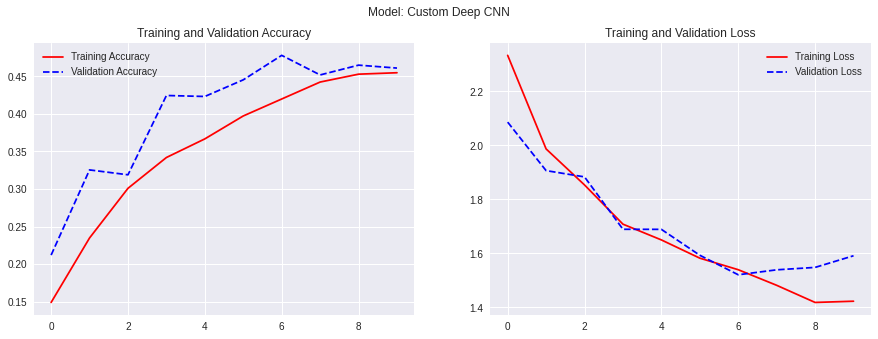

In [43]:
plt.style.use('seaborn')
plot_training(custom_history_dict, 'Custom Deep CNN')

In [44]:
# Prediction accuracy on train data
custom_score = custom_model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on Training Data: ", custom_score[1])

100/100 [==============================] - 74s 744ms/step - loss: 1.3644 - accuracy: 0.5222
Prediction accuracy on Training Data:  0.5221628546714783


In [45]:
# Prediction accuracy on CV data
vgg_score = custom_model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV Data: ", custom_score[1])

25/25 [==============================] - 18s 721ms/step - loss: 1.5896 - accuracy: 0.4671
Prediction accuracy on CV Data:  0.5221628546714783


In [46]:
p_valid, y_valid = get_predictions_and_labels(custom_model, valid_generator, STEP_SIZE_VALID)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 776 missing from current font.
  font.set_text(s, 0, flags=flags)


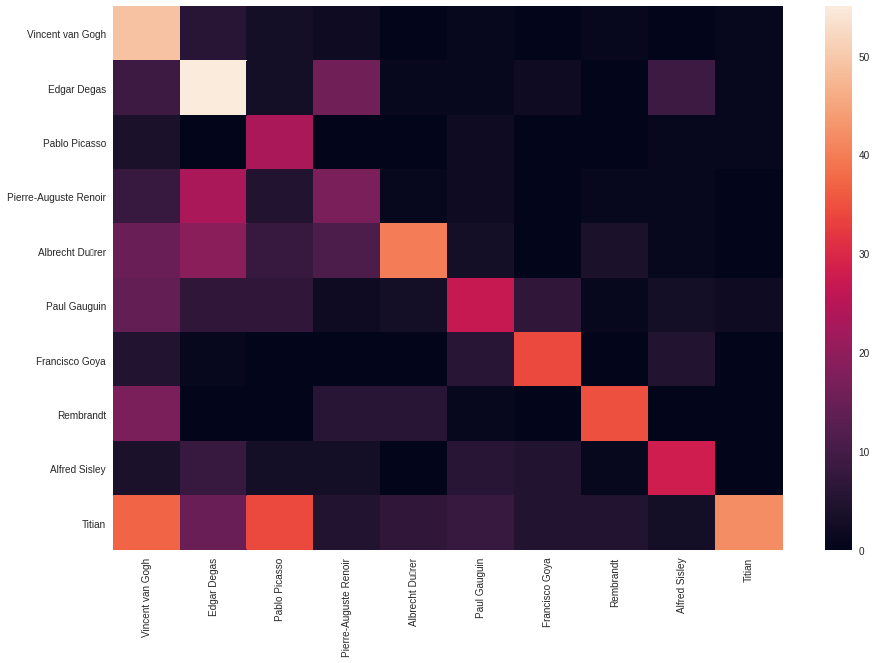

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(p_valid, y_valid)
plot_confusion_matrix(cm, 'Custom CNN')

## Predict Artwork right from the web

In [48]:
# put any url of the artwork to know the artist!
import imageio
import cv2

def predict_artist_from_web(model, url, model_name):
  web_image = imageio.imread(url)
  web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
  web_image = img_to_array(web_image)
  web_image /= 255.
  web_image = np.expand_dims(web_image, axis=0)


  prediction = model.predict(web_image)
  prediction_probability = np.amax(prediction)
  prediction_idx = np.argmax(prediction)
  print(f"Model: {model_name}")
  print(f"Predicted artist: {artists_top_name.iloc[prediction_idx].replace('_', ' ')}")
  print(f"Prediction score: {prediction_probability * 100}%", )

  plt.imshow(imageio.imread(url))
  plt.axis('off')
  plt.show()

Model: VGG16
Predicted artist: Pablo Picasso
Prediction score: 98.72552156448364%


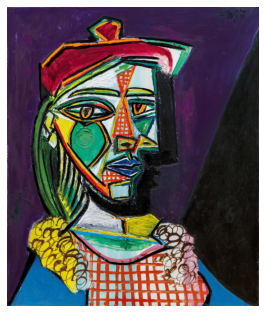

In [49]:
url = 'https://static01.nyt.com/images/2018/03/02/arts/design/02picasso-print/01picasso1-superJumbo.jpg'
predict_artist_from_web(vgg_model, url, 'VGG16')

Model: ResNet50
Predicted artist: Pablo Picasso
Prediction score: 56.35597109794617%


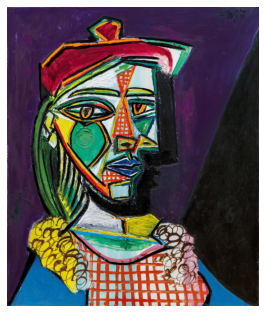

In [50]:
url = 'https://static01.nyt.com/images/2018/03/02/arts/design/02picasso-print/01picasso1-superJumbo.jpg'
predict_artist_from_web(resnet_model, url, 'ResNet50')

Model: Custom CNN
Predicted artist: Pablo Picasso
Prediction score: 45.01882493495941%


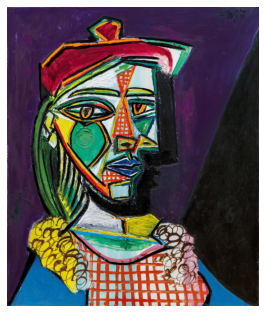

In [51]:
url = 'https://static01.nyt.com/images/2018/03/02/arts/design/02picasso-print/01picasso1-superJumbo.jpg'
predict_artist_from_web(custom_model, url, 'Custom CNN')